In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install --upgrade geopandas pyshp shapely descartes rasterio

### Import libraries

In [3]:
import io, requests, os, json

import numpy as np
import pandas as pd
import geopandas as gpd

import rasterio as rst
from rasterio.plot import show, show_hist
from rasterio.mask import mask

import matplotlib as mpl
from matplotlib import cm, colors
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [50]:
from IPython.display import Image

### GEE

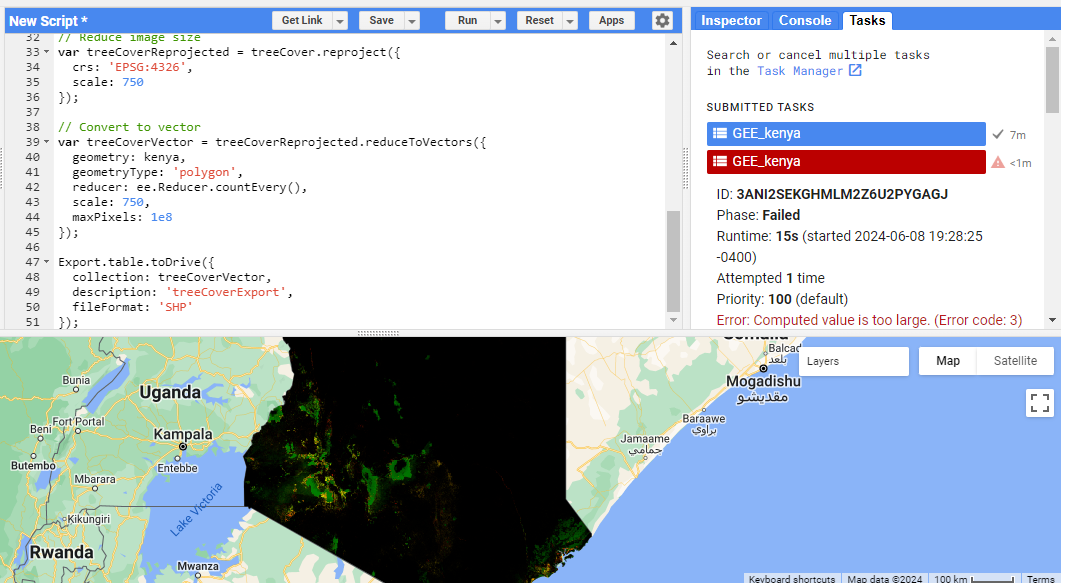

In [51]:
Image(filename='/content/GEE_KEN.png')

### Treecover

In [25]:
kenya = gpd.read_file('/content/KEN_AL2_Kenya_GEZ.json')

In [16]:
kenya_hansen = gpd.read_file('/content/drive/MyDrive/GEE_kenya.shp')

In [5]:
kenya_hansen.head(1)

,count,label,geometry
0,1,6,"POLYGON ((33.90916 0.09432, 33.90916 0.10106, ..."


In [18]:
# Filter density
kenya_forest = kenya_hansen[kenya_hansen['label'] >= 15]

In [ ]:
# Create a new column for forest type
kenya_forest['forest_type'] = 'Open forest'  # initial default

In [21]:
kenya_forest.loc[kenya_forest['label'] > 65, 'forest_type'] = 'Dense forest'
kenya_forest.loc[(kenya_forest['label'] > 40) & (kenya_forest['label'] <= 65), 'forest_type'] = 'Moderate forest'

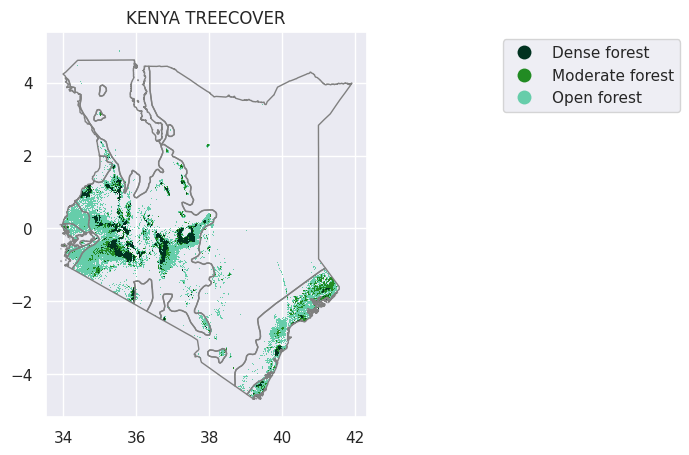

In [27]:
cmap=colors.LinearSegmentedColormap.from_list("",["#013220","#228B22","#66CDAA"])
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.set_title('KENYA TREECOVER')

kenya_forest.plot(ax=ax, column='forest_type', cmap=cmap, edgecolor='None', legend=True)
kenya.plot(ax=ax, color='None', edgecolor='gray', legend=False)

# Move the legend to the right of the map
leg = ax.get_legend()
leg.set_bbox_to_anchor((2, 1))  # (horizontal, vertical)

plt.show()

In [28]:
terreseco = gpd.read_file('/content/drive/MyDrive/geospatial/TerrestrialEcoregionsoftheWorld_WWF.geojson')

In [31]:
# Reproject CRS
if terreseco.crs != kenya_forest.crs:
    kenya_forest = kenya_forest.to_crs(terreseco.crs)

In [32]:
kenya_forest_eco = terreseco.clip(kenya_forest)

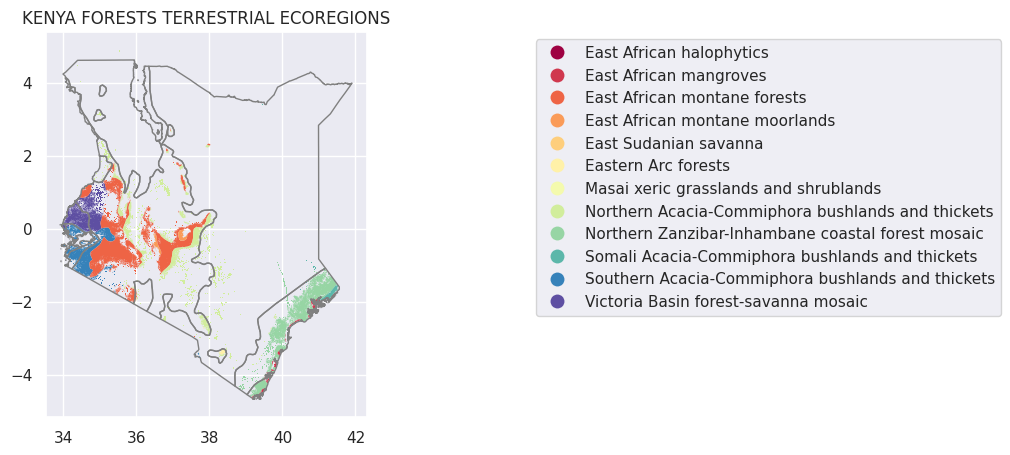

In [37]:
cmap='Spectral'
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.set_title('KENYA FORESTS TERRESTRIAL ECOREGIONS')

kenya_forest_eco.plot(ax=ax, column='ECO_NAME', cmap=cmap, edgecolor='None', legend=True)
kenya.plot(ax=ax, color='None', edgecolor='gray', legend=False)

# Move the legend to the right of the map
leg = ax.get_legend()
leg.set_bbox_to_anchor((3, 1))  # (horizontal, vertical)

plt.show()

In [38]:
holdridge = gpd.read_file('/content/drive/MyDrive/geospatial/HoldridgeLifeZones.json')

In [39]:
# Reproject CRS
if holdridge.crs != kenya_forest.crs:
    kenya_forest = kenya_forest.to_crs(holdridge.crs)

In [40]:
kenya_holdridge = holdridge.clip(kenya_forest)

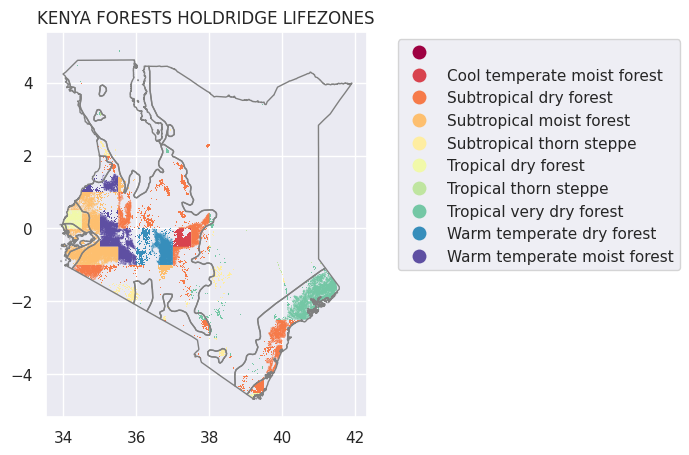

In [43]:
cmap='Spectral'
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.set_title('KENYA FORESTS HOLDRIDGE LIFEZONES')

kenya_holdridge.plot(ax=ax, column='DESC', cmap=cmap, edgecolor='None', legend=True)
kenya.plot(ax=ax, color='None', edgecolor='gray', legend=False)

# Move the legend to the right of the map
leg = ax.get_legend()
leg.set_bbox_to_anchor((2, 1))  # (horizontal, vertical)

plt.show()

In [44]:
temp_rst = '/content/drive/MyDrive/geospatial/wc2.1_2.5m_bio_1.tif'
temp_img = rst.open(temp_rst)

In [45]:
# clip raster
out_temp, out_transform = mask(temp_img, [geom for geom in kenya_forest_eco.geometry], crop=True, pad=True)
out_meta = temp_img.meta

out_meta.update({"driver": "GTiff",
                 "height": out_temp.shape[1],
                 "width": out_temp.shape[2],
                 "transform": out_transform})

with rst.open(r'Kenya-BioClim2.5m_Temperature.tiff', 'w', **out_meta) as dest:
    dest.write(out_temp)

In [46]:
# load raster
forest_temp_rst = r'Kenya-BioClim2.5m_Temperature.tiff'
forest_temp_img = rst.open(forest_temp_rst)

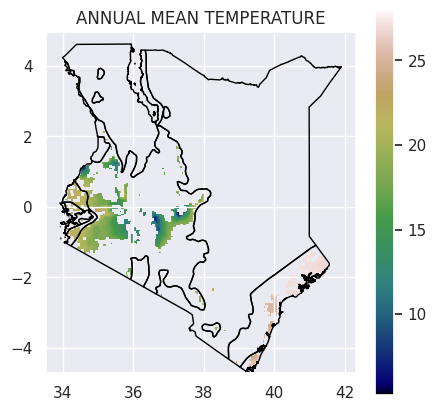

In [52]:
mpl.rc('image', cmap='gist_earth')

arr = forest_temp_img.read(1)
arr = np.where(arr < -10, np.nan, arr)

fig, ax = plt.subplots(1, 1, figsize=(5, 5))

ax.set_title('ANNUAL MEAN TEMPERATURE')
show(arr, transform=forest_temp_img.transform, ax=ax)
kenya.plot(ax=ax,color='none',edgecolor='black',legend=True)

fig.colorbar(cm.ScalarMappable(norm=colors.Normalize(vmin=np.nanmin(arr), vmax=np.nanmax(arr))), ax=ax)

plt.show()